# DEEP DREAM ONLY

In [1]:
from cStringIO import StringIO
import numpy as np
import scipy.ndimage as nd
import PIL.Image
from IPython.display import clear_output, Image, display
from google.protobuf import text_format
import caffe
def showarray(a, fmt='jpeg'):
    a = np.uint8(np.clip(a, 0, 255))
    f = StringIO()                      
    PIL.Image.fromarray(a).save(f, fmt) 
    display(Image(data=f.getvalue())) 

In [2]:
model_path = '/home/jack/Desktop/deep-dream-generator/notebooks/models/googlenet_places365/' # substitute your path here
net_fn   = model_path + 'deploy.prototxt'
param_fn = model_path + 'googlenet_places365.caffemodel'
model = caffe.io.caffe_pb2.NetParameter()           # Load the empty protobuf model,
text_format.Merge(open(net_fn).read(), model)       # Load the prototxt and load it into empty model
model.force_backward = True                         # Add the force_backward: true line
open('tmp.prototxt', 'w').write(str(model))         # Save it to a new file called tmp.prototxt
net = caffe.Classifier('tmp.prototxt', param_fn,    # Load the neural network. Using the prototxt from above
                       mean = np.float32([104.0, 117.0, 123.0]), # googlenet_places365 mean, training set dependent
                       channel_swap = (2,1,0))      # the reference model has channels in BGR order instead of RGB
def preprocess(net, img):
    return np.float32(np.rollaxis(img, 2)[::-1]) - net.transformer.mean['data']
def deprocess(net, img):
    return np.dstack((img + net.transformer.mean['data'])[::-1])
def preprocesswithoutmean(img):
    return np.float32(np.rollaxis(img, 2)[::-1])
def deprocesswithoutmean(img):
    return np.dstack(img[::-1])

In [3]:
def objective_L2(dst):          # Our training objective. Google has since release a way to load
    dst.diff[:] = dst.data      # arbitrary objectives from other images. We'll go into this later.
def make_step(net, step_size=1.5, end='inception_5a/output',      # Changed this to match my dataset (places)
              jitter=10, clip=True, objective=objective_L2):
    src = net.blobs['data'] # input image is stored in Net's 'data' blob
    dst = net.blobs[end]    # destination is the end layer specified above
    ox, oy = np.random.randint(-jitter, jitter+1, 2)            # generate random jitter
    src.data[0] = np.roll(np.roll(src.data[0], ox, -1), oy, -2) # apply jitter shift
    net.forward(end=end)     # This is how the network computes, make sure we stop on the chosen neural layer
    objective(dst)           # specify the optimization objective
    net.backward(start=end)  # Do backwards propagation, so we can compute how off we were 
    g = src.diff[0]
    src.data[:] += step_size/np.abs(g).mean() * g # get closer to our target data
    src.data[0] = np.roll(np.roll(src.data[0], -ox, -1), -oy, -2) # unshift image jitter
    if clip:                                              # If clipping is enabled
        bias = net.transformer.mean['data']               # Subtract our image mean
        src.data[:] = np.clip(src.data, -bias, 255-bias)  # clip our matrix to the values

In [4]:
def deepdream(net, base_img, iter_n=5, octave_n=5, octave_scale=1.4, 
              end='inception_5a/output', clip=True, **step_params):
    octaves = [preprocess(net, base_img)]   
    for i in xrange(octave_n-1):
        octaves.append(nd.zoom(octaves[-1], (1, 1.0/octave_scale,1.0/octave_scale), order=1))
    src = net.blobs['data']             # Again, copy the original image.
    detail = np.zeros_like(octaves[-1]) # Allocate image for network-produced details.
                                        # This creates a matrix shaped like our image, but fills it with zeroes.
    for octave, octave_base in enumerate(octaves[::-1]): # Iterate over the reversed list of images (smallest first)
        h, w = octave_base.shape[-2:]                    # Take the width and height of the current image
        if octave > 0:  # If it's not the smallest octave upscale details from the previous octave
            h1, w1 = detail.shape[-2:]
            detail = nd.zoom(detail, (1, 1.0*h/h1,1.0*w/w1), order=1) # Zoom in on the image detail, interpolate
        src.reshape(1,3,h,w) # resize the network's input image size
        src.data[0] = octave_base+detail # Add the changed details to the image
        for i in xrange(iter_n):  # number of step iterations, specified above
            make_step(net, end=end, clip=clip, **step_params) # call the function that actually runs the network
            vis = deprocess(net, src.data[0]) # Convert back to jpg format
            if not clip: # adjust image contrast if clipping is disabled
                vis = vis*(255.0/np.percentile(vis, 99.98))
            showarray(vis)
            print octave, i, end, vis.shape
            clear_output(wait=True) # clear previous input
        detail = src.data[0]-octave_base   # extract details produced on the current octave
    return deprocess(net, src.data[0]) # returning the resulting image

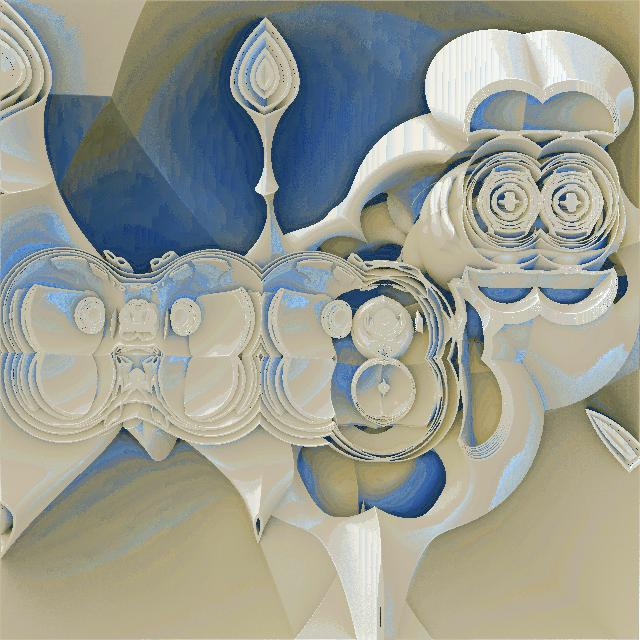

In [5]:
from IPython.display import clear_output, Image, display
imz = np.float32(PIL.Image.open('instagram/MutaGen0005.jpg'))   
showarray(imz)

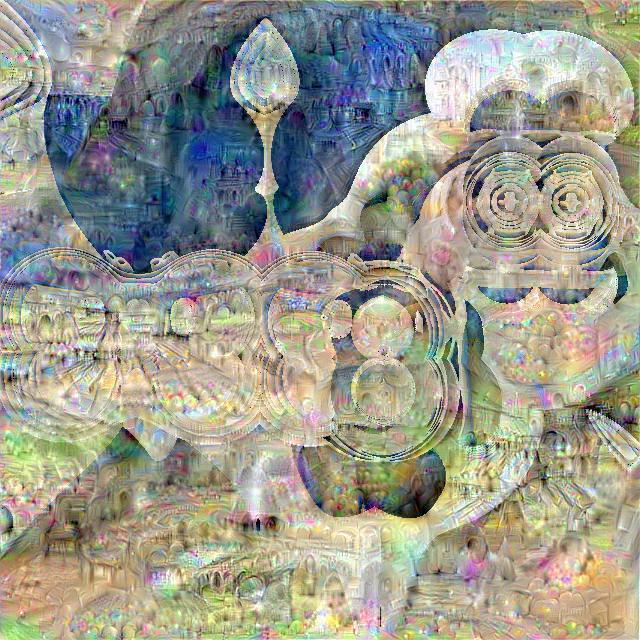

7 19 inception_5a/3x3 (640, 640, 3)


In [8]:
_=deepdream(net, imz, jitter=0, iter_n=20, octave_n=8, octave_scale=1.5, end='inception_5a/3x3')
PIL.Image.fromarray(np.uint8(_)).save("ariver001.jpg")

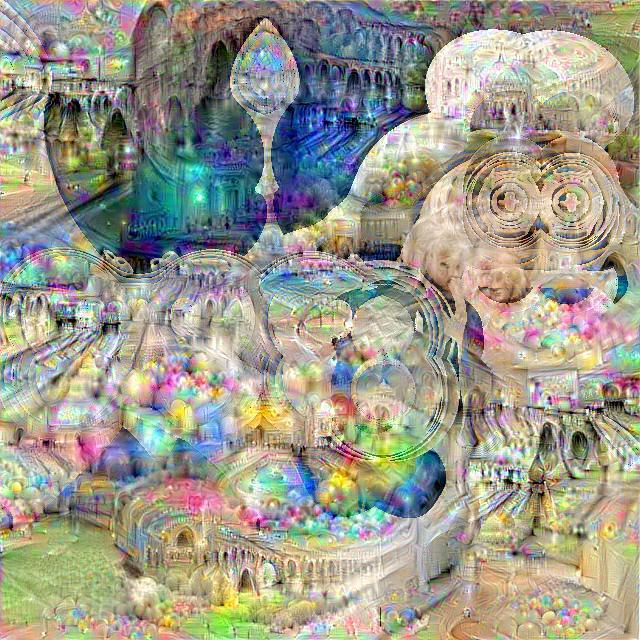

5 29 inception_5a/pool_proj (640, 640, 3)


In [7]:

new=deepdream(net, _, jitter=0, iter_n=30, octave_n=6, octave_scale=1.55, end='inception_5a/pool_proj')
PIL.Image.fromarray(np.uint8(new)).save("ariver002.jpg")